In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/'My Drive'/'Colab Notebooks'/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!rm Image_classification_data.zip
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [4]:
import numpy as np 
from sklearn.model_selection import train_test_split 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf


data = pd.read_csv('./data_labels_mainData.csv') 

In [5]:
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [6]:
data.count() #no missing values

InstanceID      9896
patientID       9896
ImageName       9896
cellTypeName    9896
cellType        9896
isCancerous     9896
dtype: int64

**Data Pre-processing**

In [7]:
#drop IDs
data.drop(['InstanceID', 'patientID'], axis = 1, inplace =True)
target = data['cellType']
data['ImgPath'] = './patch_images/' + data['ImageName']
data.head()

,ImageName,cellTypeName,cellType,isCancerous,ImgPath
0,22405.png,fibroblast,0,0,./patch_images/22405.png
1,22406.png,fibroblast,0,0,./patch_images/22406.png
2,22407.png,fibroblast,0,0,./patch_images/22407.png
3,22408.png,fibroblast,0,0,./patch_images/22408.png
4,22409.png,fibroblast,0,0,./patch_images/22409.png


In [8]:
CELLTYPE_OUTPUT_CLASSES = 4

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42) 

train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42) 

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0])) 

target = train_data['cellType']

Train data : 5937, Val Data: 1979, Test Data: 1980


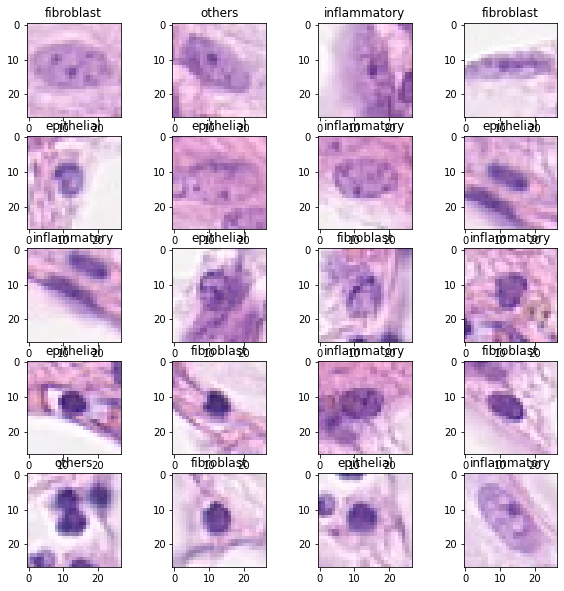

In [9]:
from PIL import Image

label_names = {'fibroblast':0, 'inflammatory':1, 'epithelial':2, 'others':3}
d_inv = {v: k for k, v in label_names.items()}

img_list = list('./patch_images/' + data['ImageName'])
target_list = list(target)
fig = plt.figure(figsize = [10, 10])
for i in np.arange(20):
    plt.subplot(5, 4, i + 1)
    img = Image.open(img_list[i])

    plt.imshow(img)
    plt.title(d_inv[target_list[i]])


In [10]:
img = Image.open(img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print('Image size \nH:{} W:{} C:{}'.format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size 
H:27 W:27 C:3


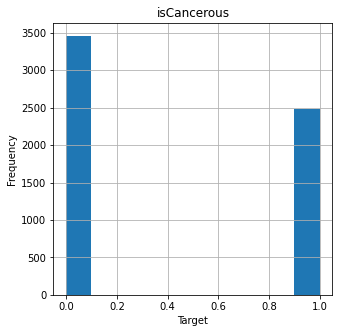

In [11]:
target = train_data['isCancerous']
target.hist(figsize=(5,5))
plt.title('isCancerous')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

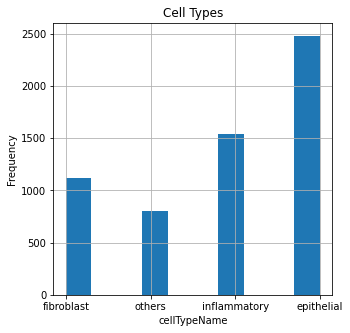

In [12]:
train_data['cellTypeName'].hist(figsize=(5,5))
plt.xlabel('cellTypeName')
plt.ylabel('Frequency')
plt.title('Cell Types')
plt.show()

In [13]:
train_data.head()
pd.DataFrame(train_data).dtypes

ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
ImgPath         object
dtype: object

In [14]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [15]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [16]:
reg_lambda = 0.001

vgg_model = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(CELLTYPE_OUTPUT_CLASSES),
])

In [17]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
vgg_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

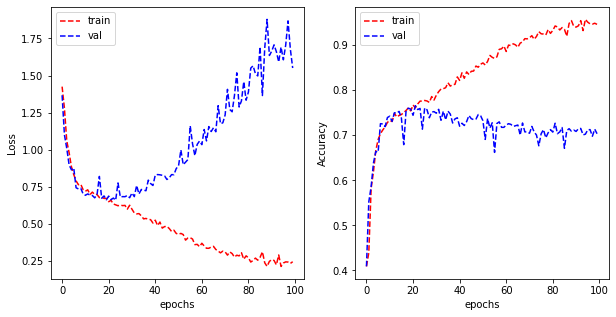

In [18]:
vgg_model_history = vgg_model.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(vgg_model_history.history['loss'], vgg_model_history.history['val_loss'], 
                    vgg_model_history.history['categorical_accuracy'], vgg_model_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [19]:
import tensorflow as tf

reg_lambda = 0.001

model = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CELLTYPE_OUTPUT_CLASSES),
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [21]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

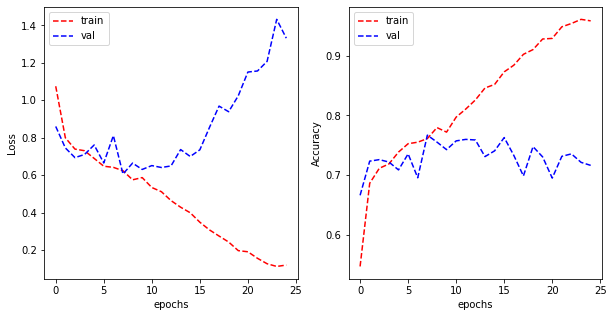

In [22]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [23]:
reg_lambda = 0.001

model_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(CELLTYPE_OUTPUT_CLASSES),
])

In [24]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

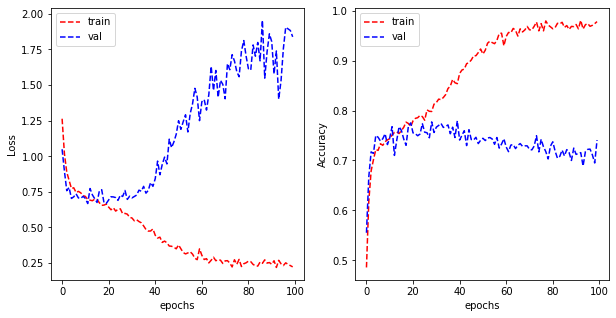

In [25]:
history_2 = model_2.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_2.history['loss'], history_2.history['val_loss'], 
                    history_2.history['categorical_accuracy'], history_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [26]:
#data augmentation

train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [27]:
reg_lambda = 0.001

model_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(CELLTYPE_OUTPUT_CLASSES),
])

In [28]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model_3.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

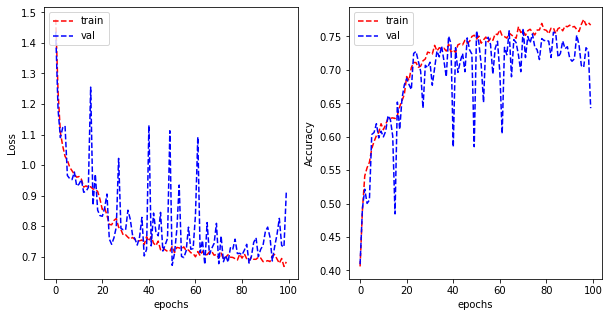

In [29]:
history_3 = model_3.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_3.history['loss'], history_3.history['val_loss'], 
                    history_3.history['categorical_accuracy'], history_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


In [30]:
# d_inv = {v: k for k, v in label_names.items()}
# plt.figure(figsize=(16,4))
# batches = 0
# for x,y in validation_generator:
#         batches = batches + 1
#         y_hat = model.predict(x, verbose=0)
#         x = np.squeeze(x)
#         if batches < 5:
#             plt.subplot(1,5,batches)
#             plt.imshow(x)
#             plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
#         else:
#             break
        
#         plt.axis('off')

In [31]:
base = tf.keras.applications.ResNet50(include_top=False, weights=None, input_tensor=(27, 27, 3))

ValueError: ignored

In [ ]:
base.summary()

In [ ]:
inputs = tf.keras.Input(shape=(9896,9896,3))
base = base(inputs)
outputs = tf.keras.layers.Dense(1)(base)
model4 = tf.keras.Model(inputs, outputs)

In [ ]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,3, activation='relu', input_shape=(27,27,3)),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.Model(inputs, outputs),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')  # activation change
])

model4.compile(optimizer='adam',
              loss='categorical_crossentropy', # Loss
              metrics=['accuracy'])

In [ ]:
history_4 = model4.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_4.history['loss'], history_4.history['val_loss'], 
                    history_4.history['categorical_accuracy'], history_4.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')